In [4]:
import pandas as pd
import datetime as dt

In [2]:
df1=pd.read_csv('Customers.csv')
df2=pd.read_csv('Transactions.csv')

In [3]:
df=pd.merge(df1,df2,on='CustomerID',how='inner')
df

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64
...,...,...,...,...,...,...,...,...,...,...
995,C0200,Kelly Cross,Asia,2023-06-11,T00518,P034,2024-12-11 03:05:50,4,868.20,217.05
996,C0200,Kelly Cross,Asia,2023-06-11,T00091,P057,2024-04-27 19:06:20,1,239.70,239.70
997,C0200,Kelly Cross,Asia,2023-06-11,T00731,P061,2024-07-15 20:36:28,4,627.84,156.96
998,C0200,Kelly Cross,Asia,2023-06-11,T00771,P048,2024-09-10 09:50:48,4,1665.60,416.40


In [6]:
data =df.groupby('CustomerID').agg(
    total_value=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    first_purchase=('TransactionDate', 'min')
).reset_index()
data['first_purchase'] = pd.to_datetime(data['first_purchase'])
data['recency'] = (pd.to_datetime('today') - data['first_purchase']).dt.days
customer_features = pd.merge(df1, data, on='CustomerID', how='inner')

In [8]:
customer_features

,CustomerID,CustomerName,Region,SignupDate,total_value,num_transactions,avg_transaction_value,first_purchase,recency
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5,670.904000,2024-01-19 03:12:55,374
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4,465.685000,2024-02-28 07:44:21,334
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4,681.345000,2024-02-18 02:50:37,344
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8,669.360000,2024-02-28 10:16:35,334
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3,678.080000,2024-03-15 04:08:59,318
...,...,...,...,...,...,...,...,...,...
194,C0196,Laura Watts,Europe,2022-06-07,4982.88,4,1245.720000,2024-08-06 14:37:15,174
195,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3,642.883333,2024-01-13 04:52:09,380
196,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2,465.915000,2024-09-29 16:14:59,120
197,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4,494.820000,2024-08-17 12:06:08,163


In [10]:
features = customer_features[['total_value','num_transactions', 'avg_transaction_value', 'recency']]

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [12]:
from sklearn.cluster import KMeans

num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

In [13]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.1518784364284205


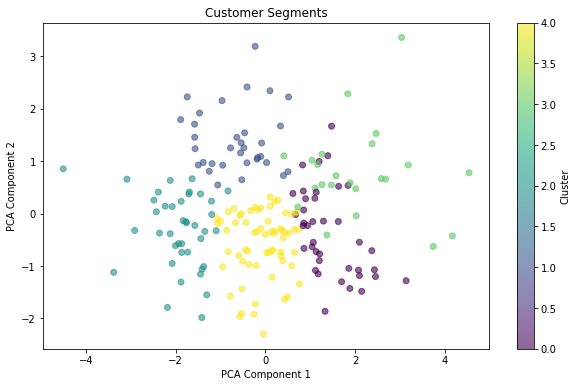

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(comp[:, 0], comp[:, 1], c=customer_features['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

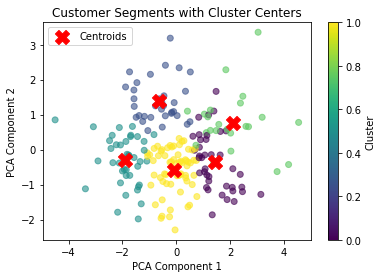

In [16]:
cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.scatter(comp[:, 0], comp[:, 1], c=customer_features['Cluster'], cmap='viridis', alpha=0.6)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('Customer Segments with Cluster Centers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

In [18]:
customer_features[['CustomerID', 'Cluster']].to_csv('FirstName_LastName_Clustering.csv', index=False)